
- **`sales_train.csv`** Rows: 2935849 sales (January 2013 -> Octuber 2015)
  - **date**: date in format dd/mm/yyyy.
  - **date_block_num**: a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
  - **shop_id**: unique identifier of a shop
  - **item_id**: unique identifier of a product
  - **item_price**: current price of an item
  - **item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure.
- **`shops.csv`** Rows: 60 shops
  - **shop_id**
  - **shop_name**: name of shop (RUSSIAN 🇷🇺)
- **`items.csv`** Rows: 22170 products
  - **item_id**
  - **item_name**: name of item (RUSSIAN 🇷🇺)
  - **item_category_id**: unique identifier of item category
- **`item_categories.csv`** Rows: 84 product categories
  - **item_category_id**
  - **item_category_name**: name of item category (RUSSIAN 🇷🇺)
- **`test.csv`** Rows: 214200 pairs combination of (Shop, Item)
  - **ID**: an Id that represents a (Shop, Item) tuple within the test set
  - **shop_id**
  - **item_id**


In [7]:
#!pip install missingno

In [89]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import missingno as m
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib as plt

In [44]:
path = "../../datasets/predict-future-sales/"

train = pd.read_csv(path+"sales_train.csv") # Daily sales  Jan 2013 -> Oct 2015
shops = pd.read_csv(path+"shops-translated.csv")       # Shops    (60)
items = pd.read_csv(path+"items-translated.csv")       # Products  (22170)
oritem = pd.read_csv(path+"items.csv")  
cats  = pd.read_csv(path+"item_categories-translated.csv") # Product categories (84)
test  = pd.read_csv(path+"test.csv", index_col="ID") # predict November 2015
sub   = pd.read_csv(path+"sample_submission.csv", index_col="ID")


In [23]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [41]:
shops

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""
5,5,"Vologda Shopping and Entertainment Center ""Mar..."
6,6,"Voronezh (Plekhanovskaya, 13)"
7,7,"Voronezh TRC ""Maksimir"""
8,8,"Voronezh TRC City-Park ""Grad"""
9,9,Outbound Trade


In [46]:
items['item_category_id'] = oritem['item_category_id']
items

,item_id,item_name_translated,item_category_id
0,0,!! IN THE POWER OF HAPPINESS (PLAST) D,40
1,1,! ABBYY FineReader 12 Professional Edition Ful...,76
2,2,*** IN THE GLORY OF THE GLORY (UNV) D,40
3,3,*** BLUE WAVE (Univ) D,40
4,4,*** BOX (GLASS) D,40
...,...,...,...
22165,22165,"Nuclear Titbit 2 [PC, Digital Version]",31
22166,22166,Query language 1C: Enterprise [Digital version],54
22167,22167,The query language is 1C: Enterprise 8 (+ CD)....,49
22168,22168,Egg for Little Inu,62


In [43]:
cats

,item_category_id,item_category_name_translated
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2
2,2,Accessories - PS3
3,3,Accessories - PS4
4,4,Accessories - PSP
...,...,...
79,79,Office
80,80,Official - Tickets
81,81,Clean carriers (spire)
82,82,Clean media (piece)


In [24]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [25]:
shops.isnull().sum()

shop_id                 0
shop_name_translated    0
dtype: int64

In [26]:
items.isnull().sum()

item_id                 0
item_name_translated    0
dtype: int64

In [27]:
cats.isnull().sum()

item_category_id                 0
item_category_name_translated    0
dtype: int64

<AxesSubplot:>

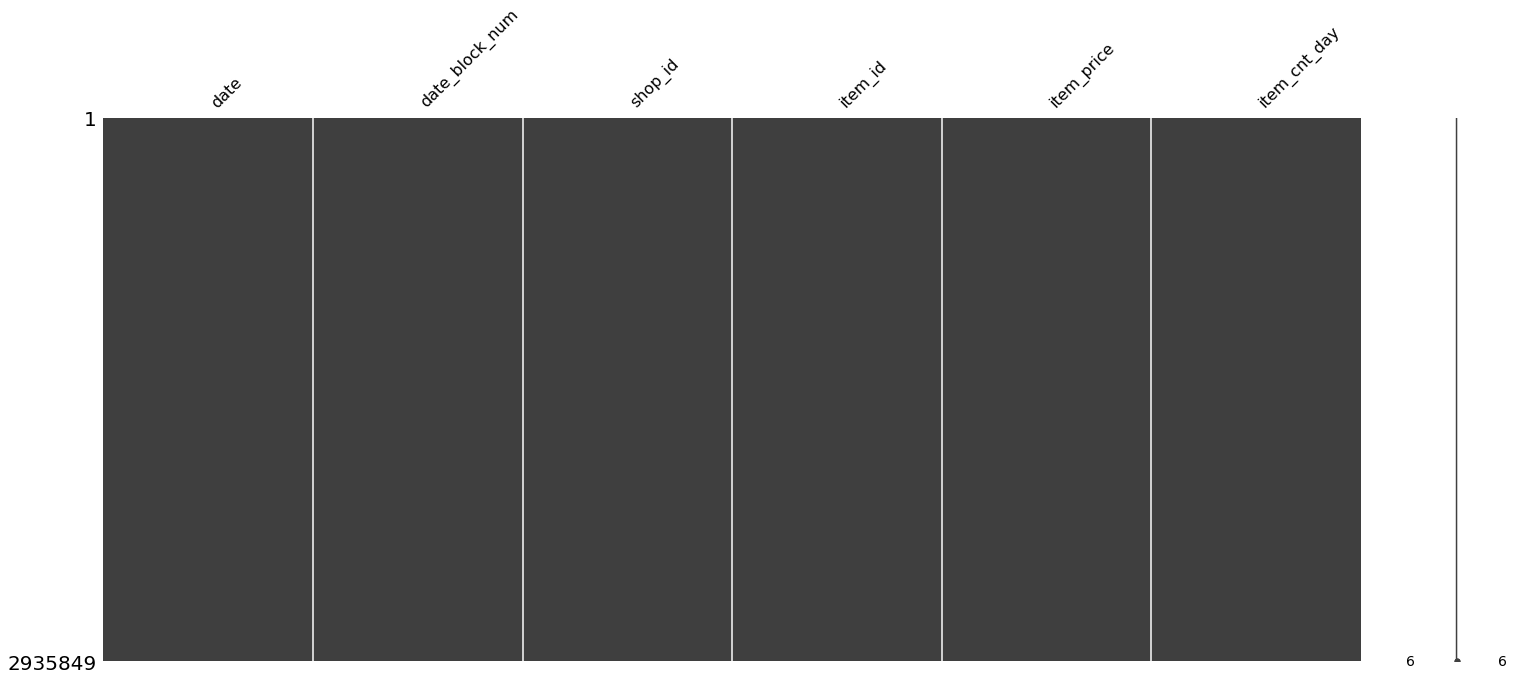

In [28]:
m.matrix(train)

In [19]:
list(train.columns.values)

['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']

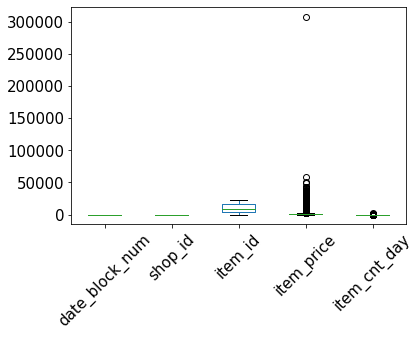

In [29]:
boxplot = train.boxplot(grid=False, rot=45, fontsize=15)

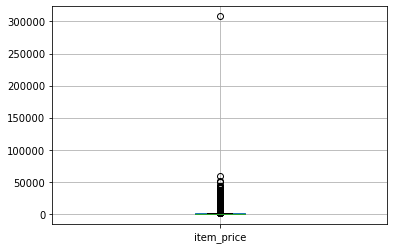

In [30]:
boxplot = train.boxplot(column=['item_price'])

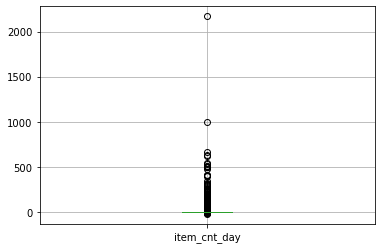

In [32]:
boxplot = train.boxplot(column=['item_cnt_day'])

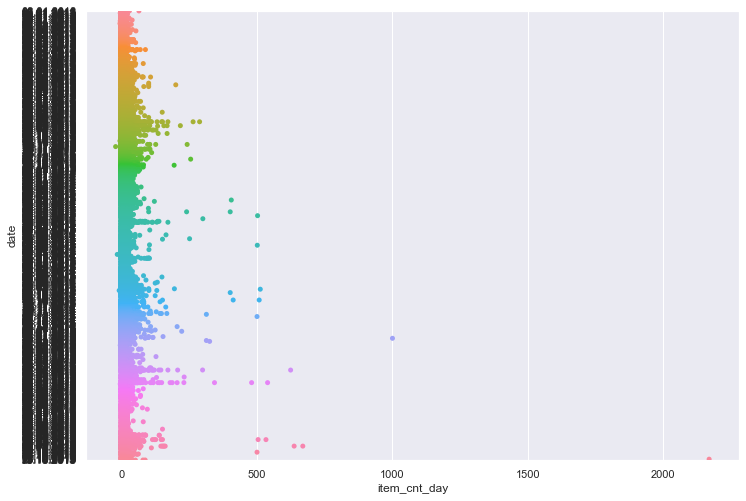

In [65]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.stripplot(y=train['date'], x=train['item_cnt_day'], data=train)

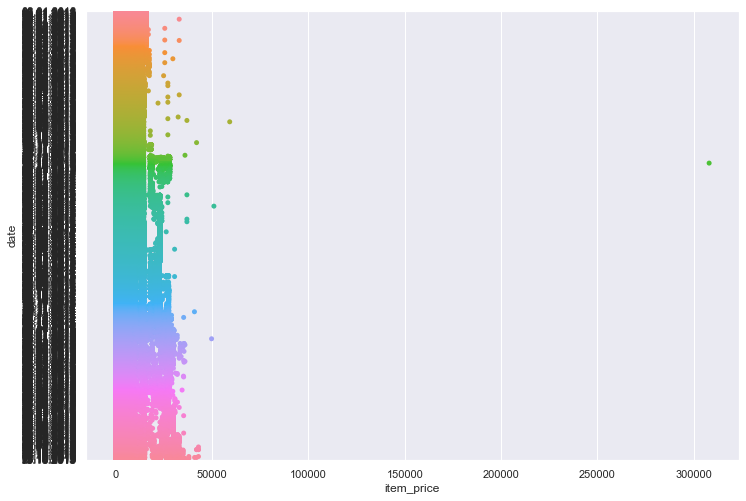

In [66]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.stripplot(y=train['date'], x=train['item_price'], data=train)

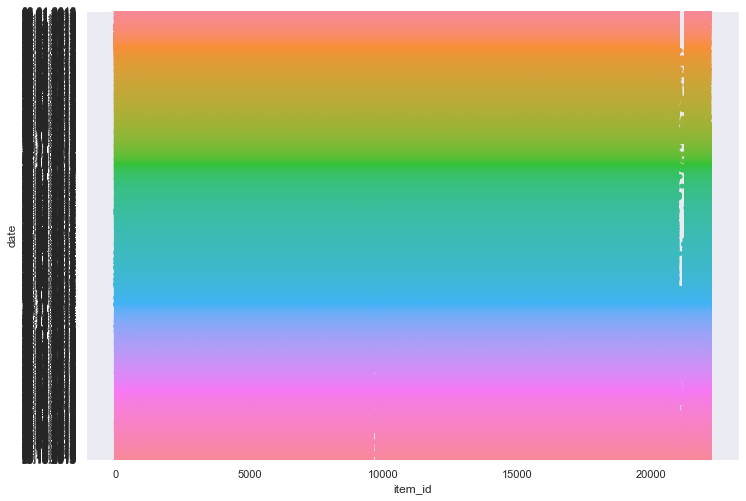

In [67]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.stripplot(y=train['date'], x=train['item_id'], data=train)

In [11]:
#Filter to obtain only the sales from Octuber 2015: date_block_num==33                 X
#Do some aggregation to convert from day detail to month detail: groupby               
#Filter the aggregated shop-item pairs to get only the pairs needed at test: merge
#Fill NaNs with zeros: .fillna(0)
#Limit your predictions to the range [0,...,20]: .clip(lower=0, upper=20)

In [61]:
hsales = train[train.item_cnt_day>150]
hsales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
566159,11.06.2013,5,12,2808,999.000000,200.0
845690,18.09.2013,8,42,3732,2521.211982,217.0
853771,18.09.2013,8,43,3732,2507.273810,168.0
858692,18.09.2013,8,18,3732,2534.000000,156.0
862929,17.09.2013,8,25,3732,2545.135417,264.0
...,...,...,...,...,...,...
2864259,30.09.2015,32,12,9252,1497.452229,157.0
2864260,29.09.2015,32,12,9248,1500.000000,504.0
2864264,30.09.2015,32,12,9244,1296.273292,161.0
2909401,14.10.2015,33,12,20949,4.000000,500.0


TypeError: cannot unpack non-iterable AxesSubplot object

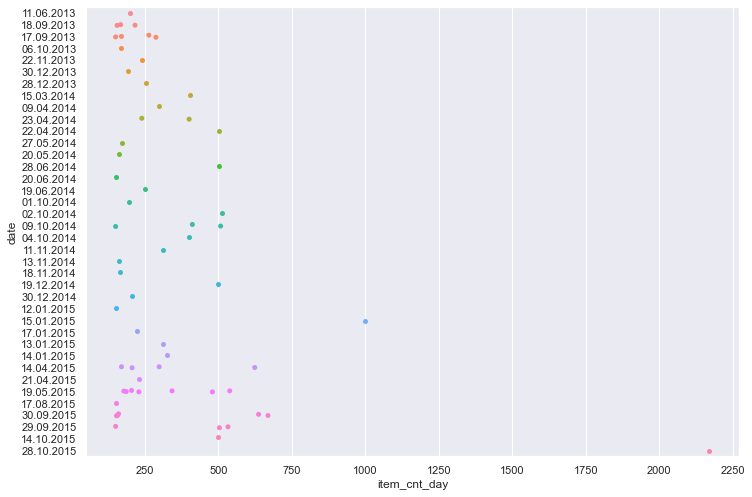

In [64]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
fig, ax = sns.stripplot(y=hsales['date'], x=hsales['item_cnt_day'], data=hsales)

In [118]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [130]:
train.date.iloc[0]

'02.01.2013'

In [125]:
str(train.date.iloc[0])

train.date = train.date.map(str)

In [149]:
def get_month_from_date(string):
        string_ret = string.split(".")[1].split(".")[0]
        return int(string_ret)


train["month"] = train['date'].map(get_month_from_date)

train["month"]

0           1
1           1
2           1
3           1
4           1
           ..
2935844    10
2935845    10
2935846    10
2935847    10
2935848    10
Name: month, Length: 2935849, dtype: int64

In [147]:
def get_year_from_date(string):
        string_ret = string.split(".")[-1]
        return int(string_ret)


train["year"] = train['date'].map(get_year_from_date)

train["year"]

0          2013
1          2013
2          2013
3          2013
4          2013
           ... 
2935844    2015
2935845    2015
2935846    2015
2935847    2015
2935848    2015
Name: year, Length: 2935849, dtype: int64

In [150]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,1,2013
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10,2015
2935845,09.10.2015,33,25,7460,299.00,1.0,10,2015
2935846,14.10.2015,33,25,7459,349.00,1.0,10,2015
2935847,22.10.2015,33,25,7440,299.00,1.0,10,2015


In [151]:
max_price = train.item_price.max()
train_dropped = train.drop(train.loc[train.item_price == max_price].index)
train_dropped = train_dropped.drop(train.loc[train.item_cnt_day > 800].index)
train_dropped

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,1,2013
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10,2015
2935845,09.10.2015,33,25,7460,299.00,1.0,10,2015
2935846,14.10.2015,33,25,7459,349.00,1.0,10,2015
2935847,22.10.2015,33,25,7440,299.00,1.0,10,2015


In [152]:
favit = train_dropped[['item_id', 'item_cnt_day']]
favit = favit.sort_values(by=['item_cnt_day'],ascending=False)
favit = favit.head(10)
favit

,item_id,item_cnt_day
2864235,9248,669.0
2851091,9249,637.0
2608040,3731,624.0
2626181,11373,539.0
2851073,9249,533.0
2048518,9242,512.0
2067669,19437,508.0
2864260,9248,504.0
1573253,8057,502.0
1708207,20949,501.0


In [153]:
favit['item_name'] = favit['item_id'].map(items.set_index('item_id')['item_name_translated'])

In [154]:
favit

,item_id,item_cnt_day,item_name
2864235,9248,669.0,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)..."
2851091,9249,637.0,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)..."
2608040,3731,624.0,"Grand Theft Auto V [PC, Russian subtitles]"
2626181,11373,539.0,Delivery to the point of issue (Boxberry)
2851073,9249,533.0,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)..."
2048518,9242,512.0,"Ticket ""Igromir 2014"" (for one day (separately..."
2067669,19437,508.0,"Middle Earth: Shadows of Mordor [PC, Digital V..."
2864260,9248,504.0,"Ticket ""IgroMir 2015"" - October 3, 2015 (site)..."
1573253,8057,502.0,iTunes 1500 руб.
1708207,20949,501.0,Corporate package T-shirt 1C Interest white (3...


<AxesSubplot:xlabel='item_name'>

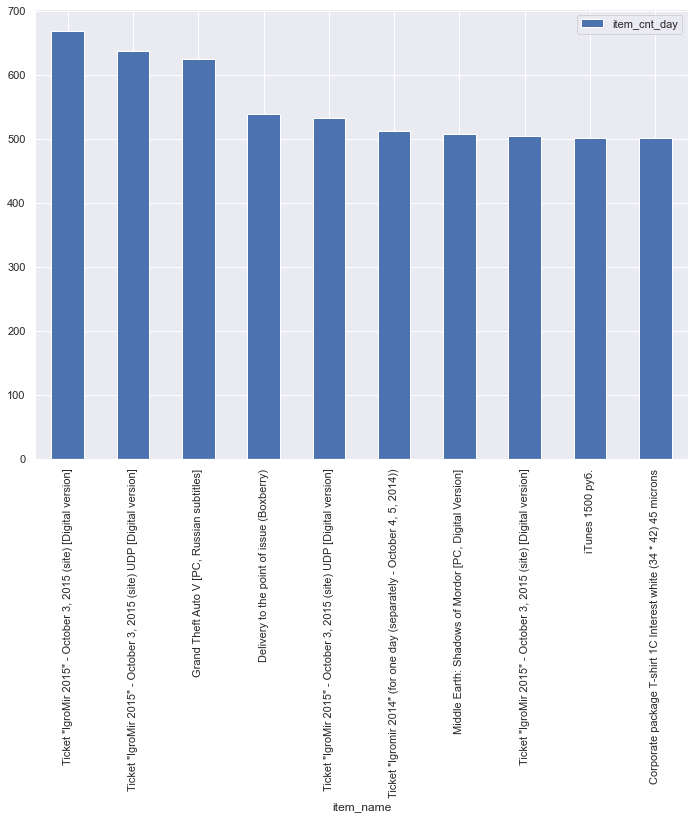

In [155]:
favit.plot.bar(y='item_cnt_day', x='item_name', style='o')

In [156]:
train_dropped

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,1,2013
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,10,2015
2935845,09.10.2015,33,25,7460,299.00,1.0,10,2015
2935846,14.10.2015,33,25,7459,349.00,1.0,10,2015
2935847,22.10.2015,33,25,7440,299.00,1.0,10,2015


In [157]:
bestshop = train_dropped[['item_id', 'item_cnt_day', 'shop_id']]
bestshop = bestshop.sort_values(by=['item_cnt_day'],ascending=False)
bestshop = bestshop.head(50)
bestshop

,item_id,item_cnt_day,shop_id
2864235,9248,669.0,12
2851091,9249,637.0,55
2608040,3731,624.0,12
2626181,11373,539.0,12
2851073,9249,533.0,55
2048518,9242,512.0,12
2067669,19437,508.0,55
2864260,9248,504.0,12
1573253,8057,502.0,27
1708207,20949,501.0,25


In [158]:
b = bestshop.groupby(["shop_id"])["item_cnt_day"].sum().reset_index()

In [159]:
b['shop_name'] = b['shop_id'].map(shops.set_index('shop_id')['shop_name_translated'])
b.sort_values(by=['item_cnt_day'],ascending=False)

,shop_id,item_cnt_day,shop_name
1,12,6195.0,Online shop Emergency
13,55,3360.0,Digital warehouse 1C-Online
4,25,1399.0,"Moscow TRK ""Atrium"""
9,42,925.0,"SPb TC ""Nevsky Center"""
5,27,903.0,"Moscow ТЦ ""MEGA Belaya Dacha II"""
7,31,630.0,"Moscow ТЦ ""Семеновский"""
12,54,613.0,"Khimki ТЦ ""Mega"""
2,15,449.0,"Kaluga TRC ""XXI Century"""
3,24,405.0,"Moscow TC ""Budenovskiy"" (pav.K7)"
10,43,335.0,"SPb TK ""Sennaya"""


<AxesSubplot:xlabel='shop_name'>

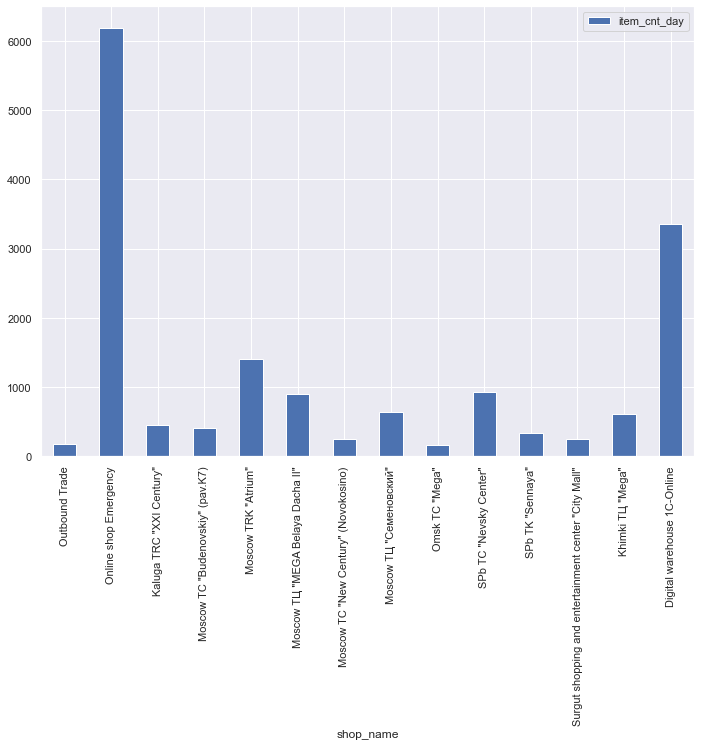

In [160]:
b.plot.bar(y='item_cnt_day', x='shop_name', style='o')

array([[<AxesSubplot:title={'center':'date_block_num'}>,
        <AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

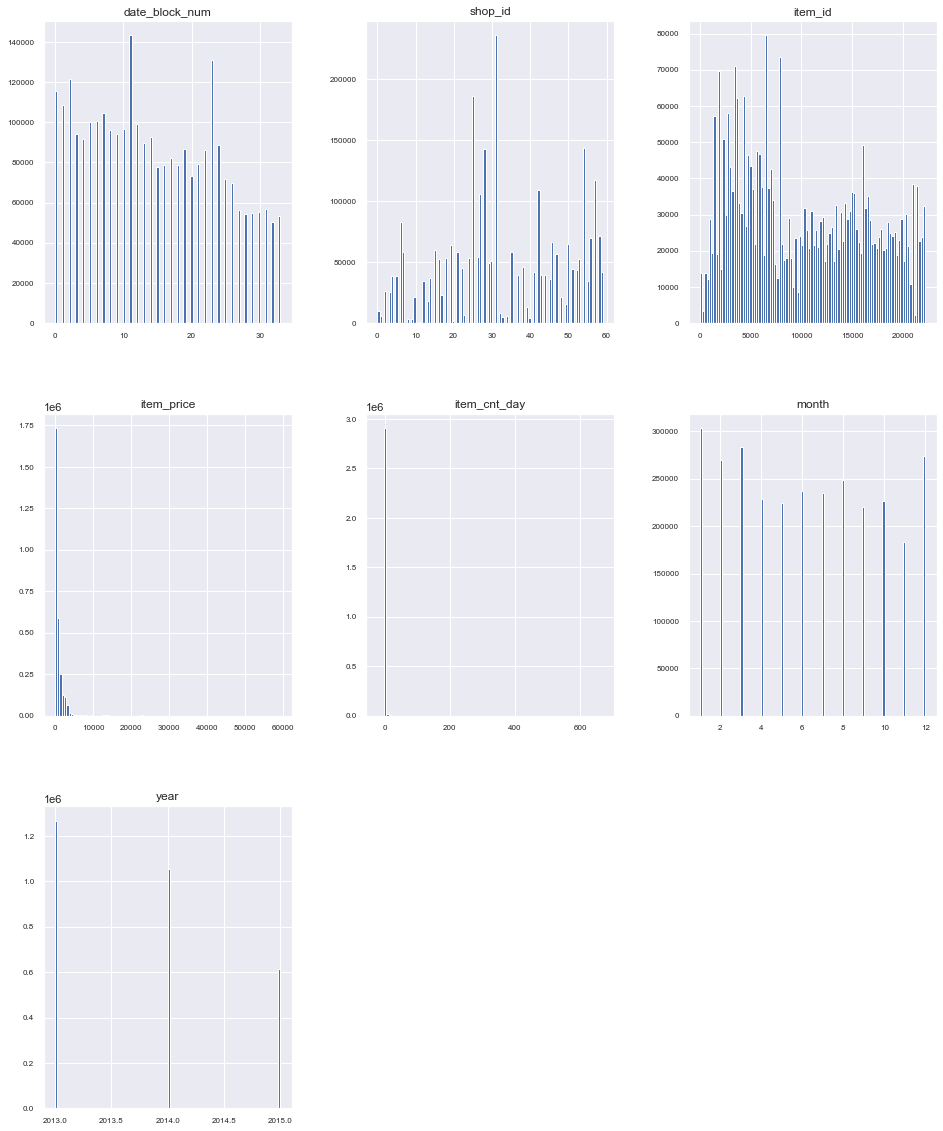

In [161]:
train_dropped.hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8)

In [175]:
bestmonths = train_dropped[['item_id', 'item_cnt_day', 'shop_id', 'month']]
bestmonths = bestmonths.sort_values(by=['item_cnt_day'],ascending=False)
bestmonths = bestmonths.head(50)
bestmonths

,item_id,item_cnt_day,shop_id,month
2864235,9248,669.0,12,9
2851091,9249,637.0,55,9
2608040,3731,624.0,12,4
2626181,11373,539.0,12,5
2851073,9249,533.0,55,9
2048518,9242,512.0,12,10
2067669,19437,508.0,55,10
2864260,9248,504.0,12,9
1573253,8057,502.0,27,4
1708207,20949,501.0,25,6


<AxesSubplot:xlabel='month'>

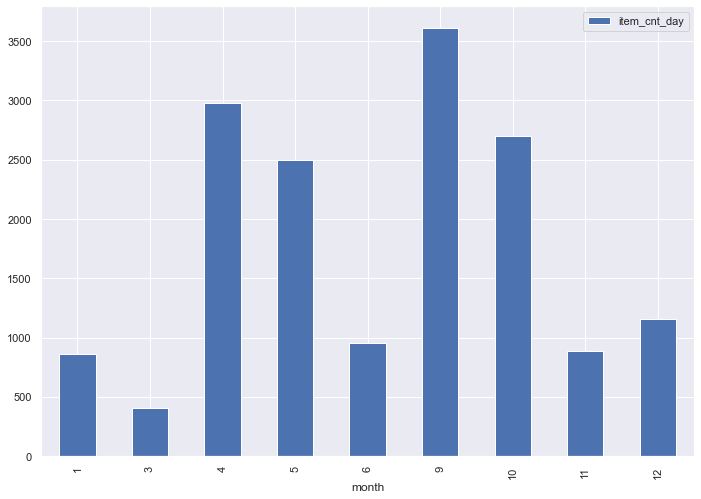

In [183]:
bs = bestmonths.groupby(["month"])["item_cnt_day"].sum().reset_index()
bs
bs.plot.bar(y='item_cnt_day', x='month', style='o')

<AxesSubplot:xlabel='month'>

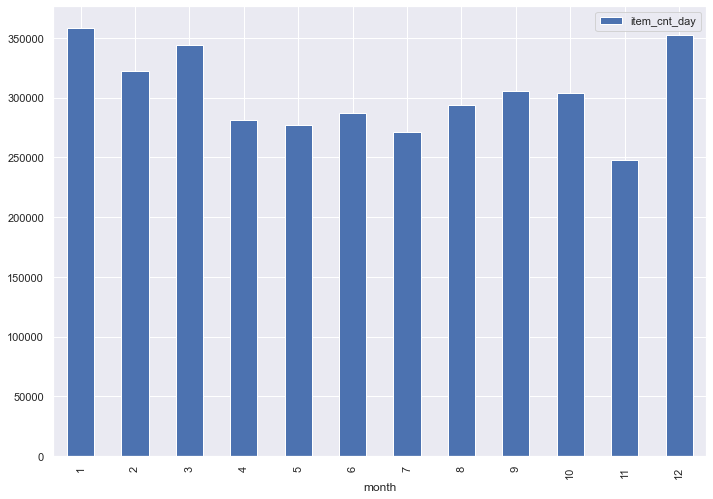

In [182]:
bsall = train_dropped.groupby(["month"])["item_cnt_day"].sum().reset_index()
bsall
bsall.plot.bar(y='item_cnt_day', x='month', style='o')

In [174]:
bestyear = train_dropped[['item_id', 'item_cnt_day', 'shop_id', 'year']]
bestyear = bestyear.sort_values(by=['item_cnt_day'],ascending=False)
bestyear = bestyear.head(50)
bestyear

,item_id,item_cnt_day,shop_id,year
2864235,9248,669.0,12,2015
2851091,9249,637.0,55,2015
2608040,3731,624.0,12,2015
2626181,11373,539.0,12,2015
2851073,9249,533.0,55,2015
2048518,9242,512.0,12,2014
2067669,19437,508.0,55,2014
2864260,9248,504.0,12,2015
1573253,8057,502.0,27,2014
1708207,20949,501.0,25,2014


<AxesSubplot:xlabel='year'>

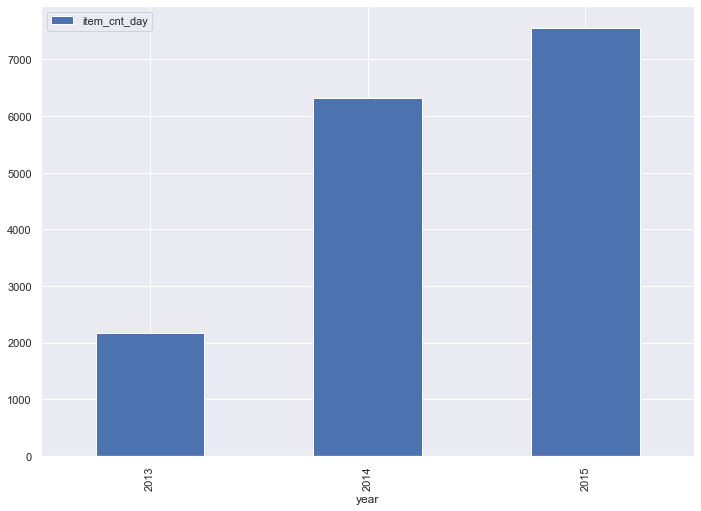

In [185]:
by = bestyear.groupby(["year"])["item_cnt_day"].sum().reset_index()
by
by.plot.bar(y='item_cnt_day', x='year', style='o')

<AxesSubplot:xlabel='year'>

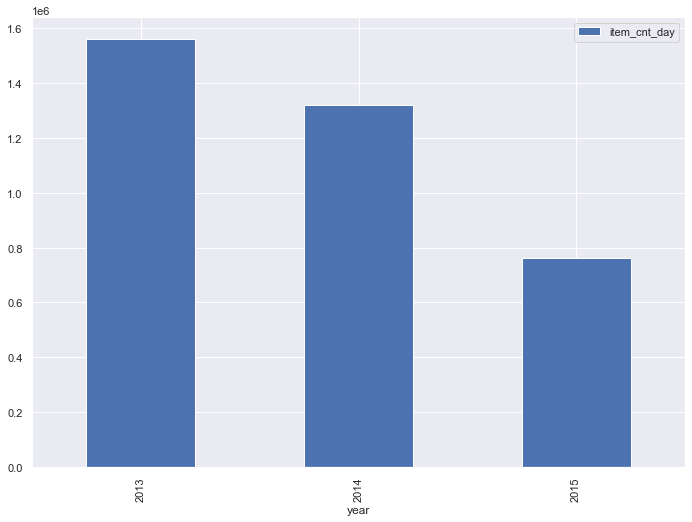

In [184]:
byall = train_dropped.groupby(["year"])["item_cnt_day"].sum().reset_index()
byall
byall.plot.bar(y='item_cnt_day', x='year', style='o')